In [5]:
!pip install --user --upgrade pip

!pip install h5py
!pip install keras

Requirement already up-to-date: pip in c:\users\lucas\appdata\roaming\python\python36\site-packages (19.1.1)


In [39]:
import h5py

ancho_imagen = 384
cantidad_imagenes = 497
split = int((cantidad_imagenes/2)*ancho_imagen)

data_file = h5py.File('data1D.h5', 'r')

dinput = data_file['dinput']
doutput = data_file['doutput']

dishape = dinput[0].shape

print(dinput.shape)
print(doutput.shape)

data_n = doutput.shape[0]

train_images, train_labels = dinput[:split].copy(), doutput[:split].copy()
test_images, test_labels =  dinput[split:].copy(), doutput[split:].copy()

#train_labels = train_labels.reshape((250, doutput.shape[1], doutput.shape[2], 1))
#test_labels = test_labels.reshape((data_n - 250, doutput.shape[1], doutput.shape[2], 1))

print(test_labels.shape)

data_file.close()

(190848, 288, 3)
(190848, 36, 1)
(95424, 36, 1)


In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from keras import layers
from keras import models
from keras import backend as K

K.clear_session()

model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=dishape, padding='same'))
model.add(layers.Conv1D(32, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu', padding='same'))
model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(1, 3, activation='sigmoid', padding='same'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 288, 64)           640       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 288, 32)           6176      
_________________________________________________________________
batch_normalization_1 (Batch (None, 288, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 144, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 144, 128)          12416     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 144, 64)           24640     
_________________________________________________________________
batch_normalization_2 (Batch (None, 144, 64)           256       
__________

In [54]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=[precision_m])
history = model.fit(train_images, train_labels, epochs=5, batch_size=5000, validation_split = 0.2)

Train on 76339 samples, validate on 19085 samples
Epoch 1/5
76339/76339 [==============================] - 466s 6ms/step - loss: 0.0933 - precision_m: 0.6682 - val_loss: 0.2634 - val_precision_m: 0.4608
Epoch 2/5
76339/76339 [==============================] - 268s 4ms/step - loss: 0.0883 - precision_m: 0.6893 - val_loss: 0.2629 - val_precision_m: 0.4900
Epoch 3/5
76339/76339 [==============================] - 407s 5ms/step - loss: 0.0882 - precision_m: 0.6822 - val_loss: 0.3082 - val_precision_m: 0.2155
Epoch 4/5
76339/76339 [==============================] - 388s 5ms/step - loss: 0.0868 - precision_m: 0.6896 - val_loss: 0.2751 - val_precision_m: 0.3391
Epoch 5/5
76339/76339 [==============================] - 430s 6ms/step - loss: 0.0869 - precision_m: 0.6874 - val_loss: 0.2889 - val_precision_m: 0.2523


In [40]:
_, precision = model.evaluate(test_images, test_labels, batch_size=500)
print(precision)

95424/95424 [==============================] - 77s 805us/step
0.11234715080661066


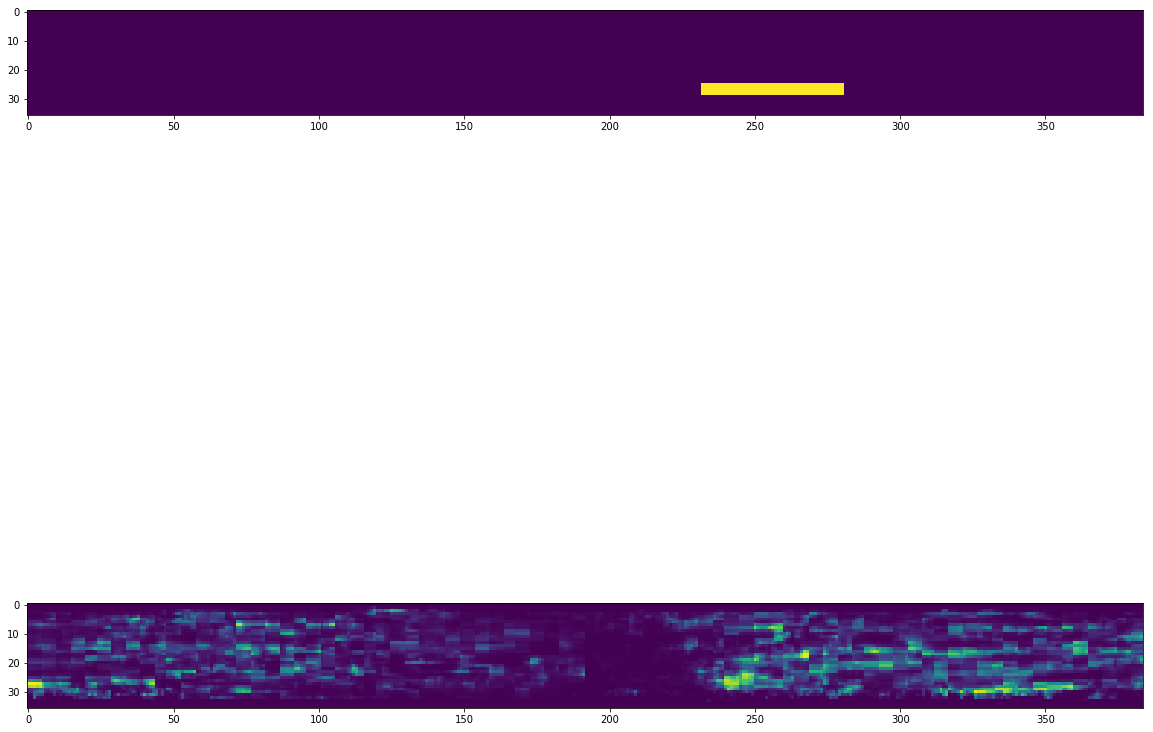

In [55]:
import numpy as np

index = 200
ancho_imagen = 384

offset = index*ancho_imagen

imagen_input = np.zeros((288, ancho_imagen, 3))
imagen_output = np.zeros((36, ancho_imagen))
imagen_predict = np.zeros((36, ancho_imagen, 1))

for x in range(ancho_imagen):    
    imagen_input[:, x, :] = test_images[offset + x, :, :]
    imagen_output[:, x] = test_labels[offset + x, :, 0]
    imagen_predict[:, x] = model.predict(test_images[(offset + x):(offset + x + 1), :, :])
    
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))

#fig.add_subplot(1, 3, 1)                
#plt.imshow(imagen_input)        
fig.add_subplot(2, 1, 1)
plt.imshow(imagen_output)
fig.add_subplot(2, 1, 2)
plt.imshow(imagen_predict[:, :, 0])

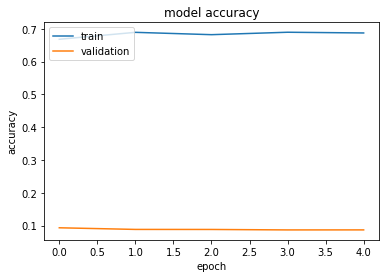

In [56]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()